# ML Defect Morphology Physics: Part 2

**Objective**: Quantify the limits of morphological information, establish rigorous baselines, analyze locality breakdown, and decompose variance into physical components.

**Key Goals**:
1.  **Information Upper Bound Test**: Quantify how much variance is actually explainable by morphology vs spatial drift vs noise.
2.  **Locality Scaling**: Determine the physical interaction length scale by analyzing prediction saturation with increasing radius.
3.  **Variance Decomposition**: Formal split of $Var(Y) = Var_{local} + Var_{global} + Var_{noise}$.
4.  **Predictability Phase Diagrams**: Map where the model works (Dense/Proximal) vs where it fails (Sparse/Distal).

**Structure**:
-   **Section 1**: Setup & Feature Definitions
-   **Section 2**: Information Upper Bound Analysis
-   **Section 3**: Locality Breakdown Scale
-   **Section 4**: Variance Decomposition
-   **Section 5**: Predictability Phase Diagrams

## SECTION 1: Setup & Feature Definitions

In [1]:
import sys
import os
from pathlib import Path

# Add src directory to path
current_dir = Path(os.getcwd())
root_dir = current_dir.parent if current_dir.name == 'notebooks' else current_dir
src_dir = str(root_dir / "src")
if src_dir not in sys.path:
    sys.path.append(src_dir)

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import GroupKFold, cross_validate, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

# Ensure project root is in path
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from defect_analysis.ml import ftir_utils, dataset_assembly, ml_models

# Plotting Setup
plt.rcParams.update({
    "figure.dpi": 150,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "DejaVu Sans"],
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.titlesize": 16
})

# Paths
DATA_DIR = PROJECT_ROOT / "data"
RESULTS_DIR = PROJECT_ROOT / "results"
OUTPUT_DIR = PROJECT_ROOT / "ml_outputs" / "Physics_Part2"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Project Root: {PROJECT_ROOT}")

Project Root: c:\Users\srfdyz\OneDrive - University of Missouri\Desktop\Defects\Autonomous_Defects


In [2]:
# Load Data (Reuse logic from Part 1)
try:
    array_data = ftir_utils.load_all_arrays(str(DATA_DIR))
    class_csv = RESULTS_DIR / "meta_atoms_classified.csv"
    classifications = ftir_utils.load_classifications(str(class_csv))
    print("Data loaded.")
except Exception as e:
    print(f"Error loading data: {e}")

# Build Master Dataset
print("Building master dataset...")
master_df, baselines = dataset_assembly.build_master_dataset(array_data, classifications)

# Basic Cleaning
dist_cols = ['min_defect_dist', 'mean_defect_dist']
for col in dist_cols:
    max_val = master_df[col].max(skipna=True)
    fill_val = max_val * 2 if not np.isnan(max_val) else 1000.0
    master_df[col].fillna(fill_val, inplace=True)

for col in dataset_assembly.TOPOLOGY_COLS:
    if col in master_df.columns:
        master_df[col].fillna(0, inplace=True)

# Define Spatial Groups
master_df['block_row'] = (master_df['global_row'] - 1) // 5
master_df['block_col'] = (master_df['global_col'] - 1) // 5
master_df['spatial_group'] = (
    master_df['array'].astype(str) + "_" + 
    master_df['block_row'].astype(str) + "_" + 
    master_df['block_col'].astype(str)
)

print(f"Dataset Shape: {master_df.shape}")

Data loaded.
Building master dataset...
  Assembling Array_1.0 ...
    Processed 169 measurements.
  Assembling Array_2.0 ...
    Processed 169 measurements.
  Assembling Array_3.0 ...
    Processed 169 measurements.
Dataset Shape: (507, 40)


C:\Users\srfdyz\AppData\Local\Temp\ipykernel_46976\1309899793.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  master_df[col].fillna(fill_val, inplace=True)
C:\Users\srfdyz\AppData\Local\Temp\ipykernel_46976\1309899793.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

### 1.1 Define Feature Sets

We rigorously define three sets of features:
1.  **Morphology ($X_{morph}$)**: Strictly local defect features (counts, distances, topology).
2.  **Spatial ($X_{spatial}$)**: Global coordinates (row/col) and polynomial terms. Represents systematic gradients.
3.  **Combined ($X_{combined}$)**: Both.
4.  **Random Baseline ($X_{shuffled}$)**: Morphology features with shuffled labels.

In [3]:
# 1. Morphology Features
feat_morph = dataset_assembly.INPUT_COLS

# 2. Spatial Features
# Create polynomial spatial features (x, y, x^2, y^2, xy)
spatial_raw = master_df[['global_row', 'global_col']].values
poly = PolynomialFeatures(degree=3, include_bias=False)
spatial_poly = poly.fit_transform(spatial_raw)
feat_spatial_names = [f"spatial_{i}" for i in range(spatial_poly.shape[1])]

# Add to DF for easy access
spatial_df = pd.DataFrame(spatial_poly, columns=feat_spatial_names, index=master_df.index)
master_df = pd.concat([master_df, spatial_df], axis=1)
feat_spatial = feat_spatial_names

# 3. Combined
feat_combined = feat_morph + feat_spatial

print(f"Morphology Features ({len(feat_morph)}): {feat_morph[:5]}...")
print(f"Spatial Features ({len(feat_spatial)}): {feat_spatial[:5]}...")

Morphology Features (25): ['n_missing', 'n_collapsed', 'n_stitching', 'n_irregular', 'n_total_defects']...
Spatial Features (9): ['spatial_0', 'spatial_1', 'spatial_2', 'spatial_3', 'spatial_4']...


## SECTION 2: Information Upper Bound Test

We train models on each feature set to establish:
-   $R^2_{shuffled}$: The noise floor (should be $\approx 0$).
-   $R^2_{spatial}$: The predictability due to fabrication gradients.
-   $R^2_{morph}$: The predictability due to local defects.
-   $R^2_{combined}$: The total explainable variance.

**Hypothesis**:
-   Magnitude ($T$) is dominated by $X_{morph}$.
-   Wavelength ($\lambda$) is dominated by $X_{spatial}$.

In [4]:
def eval_feature_set(name, input_cols, target_col, df, groups, shuffle=False):
    X = df[input_cols].values
    y = df[target_col].values
    
    # Standard Cleaning
    mask = ~np.isnan(y)
    X = X[mask]
    y = y[mask]
    g = groups[mask]
    
    if shuffle:
        # Shuffle X along samples axis, breaking link to y
        # We shuffle X instead of y to keep y-distrib same, but break feature link
        idx = np.random.permutation(len(X))
        X = X[idx]
    
    model = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
    
    cv = GroupKFold(n_splits=5)
    scores = cross_validate(model, X, y, groups=g, scoring='r2', cv=cv)
    
    return scores['test_score'].mean(), scores['test_score'].std()

results = []
groups = master_df['spatial_group'].values

targets = ['delta_peak_wl', 'delta_peak_mag']
feature_sets = {
    'Baseline (Shuffled)': (feat_morph, True),
    'Spatial Only': (feat_spatial, False),
    'Morphology Only': (feat_morph, False),
    'Combined': (feat_combined, False)
}

print("Running Upper Bound Analysis...")

for tgt in targets:
    print(f"  Target: {tgt}")
    for fs_name, (cols, do_shuffle) in feature_sets.items():
        r2_mean, r2_std = eval_feature_set(fs_name, cols, tgt, master_df, groups, shuffle=do_shuffle)
        print(f"    {fs_name}: {r2_mean:.3f} (+/- {r2_std:.3f})")
        results.append({
            'Target': tgt,
            'Feature Set': fs_name,
            'R2': r2_mean,
            'R2_Std': r2_std
        })
        
res_df = pd.DataFrame(results)

Running Upper Bound Analysis...
  Target: delta_peak_wl
    Baseline (Shuffled): -0.206 (+/- 0.116)
    Spatial Only: -0.449 (+/- 0.364)
    Morphology Only: -0.278 (+/- 0.369)
    Combined: -0.275 (+/- 0.198)
  Target: delta_peak_mag
    Baseline (Shuffled): -0.246 (+/- 0.125)
    Spatial Only: 0.828 (+/- 0.059)
    Morphology Only: 0.775 (+/- 0.024)
    Combined: 0.774 (+/- 0.009)


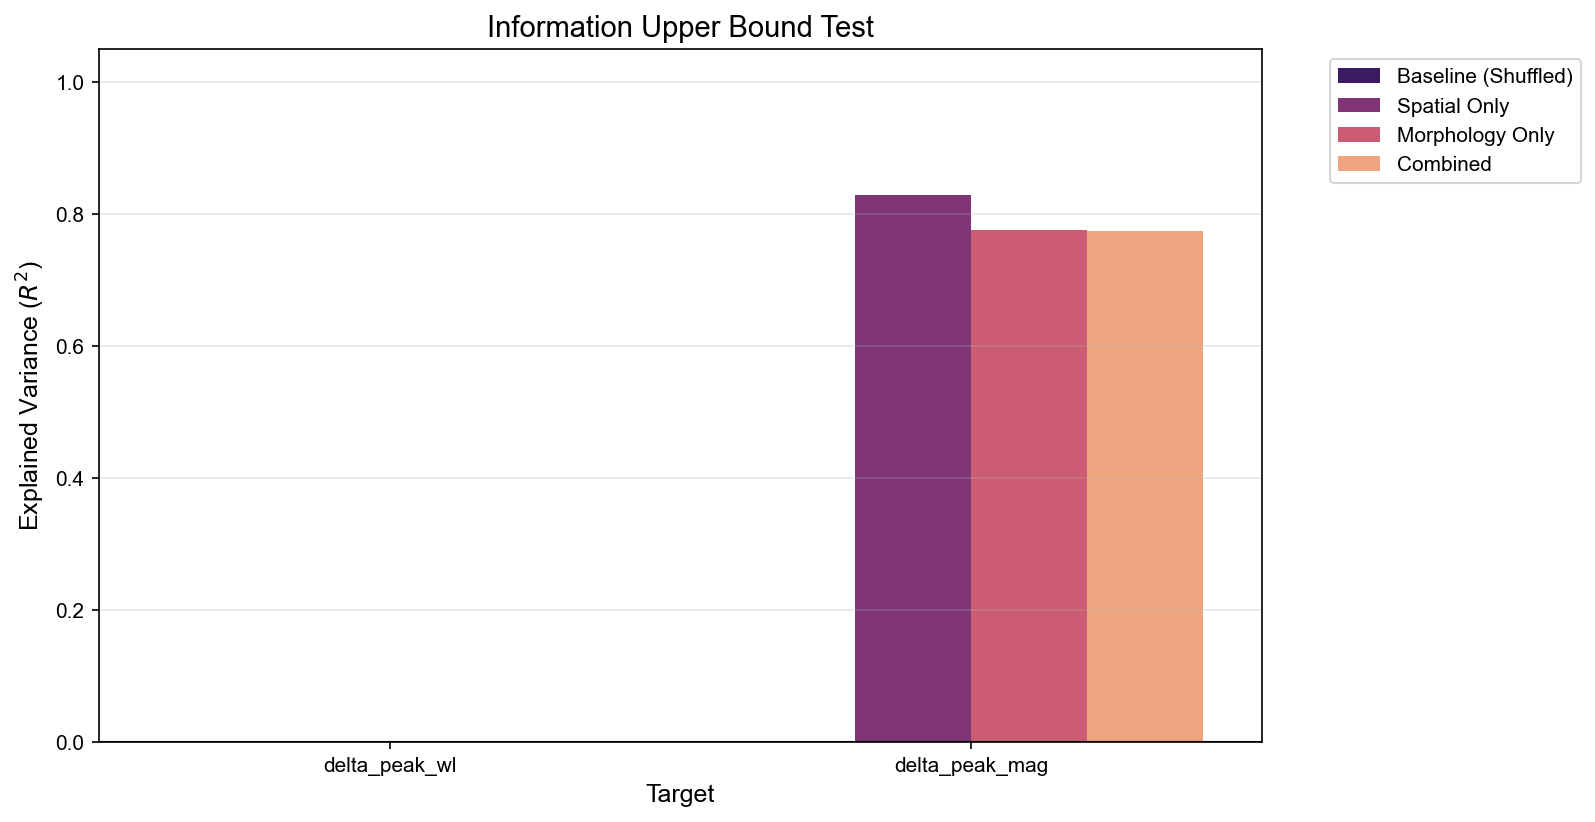

In [5]:
# Visualizing Information Bound
plt.figure(figsize=(10, 6))
sns.barplot(data=res_df, x='Target', y='R2', hue='Feature Set', palette='magma')
plt.title('Information Upper Bound Test')
plt.ylabel('Explained Variance ($R^2$)')
plt.ylim(0, 1.05)
plt.grid(axis='y', alpha=0.3)
plt.axhline(0, color='k', linewidth=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig(OUTPUT_DIR / "Fig1_Information_Upper_Bound.png", dpi=300, bbox_inches='tight')
plt.show()

## SECTION 3: Locality Breakdown Scale

We determine the **Physical Interaction Length** by observing how prediction accuracy ($R^2$) changes as we include defects from wider and wider radii.

**Method**:
1.  For radius $r \in [10, 25, 40, 55, 70, 100]$ microns:
    -   Calculate `n_defects_within_r` for each measurement point.
    -   Train a regressor using ONLY this feature (and `dist_to_nearest` if $< r$).
2.  Plot $R^2$ vs $r$.
3.  Identify saturation point.

In [6]:
from scipy.spatial.distance import cdist

def get_defects_in_radius(row, defect_coords, radius_um):
    # Center coordinate (um)
    # Standard pitch is 1.6um, assuming global coordinates align with this or using direct um values
    # The current datasets use grid indices (1..260). We assume 1 unit = 1.6 microns roughly, or just use grid units.
    # Let's assume indices are grid units. 1 unit ~ 1.6um.
    
    center_r, center_c = row['global_row'], row['global_col']
    
    # Filter broadly first
    mask = (
        (defect_coords[:,0] > center_r - radius_um) & 
        (defect_coords[:,0] < center_r + radius_um) & 
        (defect_coords[:,1] > center_c - radius_um) & 
        (defect_coords[:,1] < center_c + radius_um)
    )
    local_defs = defect_coords[mask]
    
    if len(local_defs) == 0:
        return 0
        
    dists = np.sqrt((local_defs[:,0] - center_r)**2 + (local_defs[:,1] - center_c)**2)
    return np.sum(dists <= radius_um)

# Pre-compute defect coordinates per array to speed up
defect_coords_map = {}
for arr in master_df['array'].unique():
    # Filter classification dict
    if arr not in classifications: continue
    df_cls = classifications[arr]
    
    # Get coords of NON-nominal atoms
    defects = df_cls[df_cls['classification'] != 'Nominal']
    coords = defects[['row', 'col']].values
    defect_coords_map[arr] = coords

# Define Radii (in grid units)
# 10 grid units ~ 16um, 50 units ~ 80um
radii = [2, 5, 10, 15, 20, 30, 40, 50, 75]
results_scaling = []

print("Running Locality Scaling Analysis...")
target_col = 'delta_peak_mag' # Focus on magnitude as it is morphology-driven

for r in radii:
    print(f"  Radius: {r} grid units")
    
    # Generate feature column for this radius
    col_name = f'defects_r{r}'
    counts = []
    for _, row in master_df.iterrows():
        arr = row['array']
        if arr in defect_coords_map:
            cnt = get_defects_in_radius(row, defect_coords_map[arr], r)
        else:
            cnt = 0
        counts.append(cnt)
    
    master_df[col_name] = counts
    
    # Train model on JUST this feature + min_dist (always relevant)
    feat_subset = ['min_defect_dist', col_name]
    r2_mean, r2_std = eval_feature_set(
        f'Radius {r}', feat_subset, target_col, master_df, groups, shuffle=False
    )
    
    results_scaling.append({
        'Radius': r,
        'R2': r2_mean,
        'R2_Std': r2_std
    })

scaling_df = pd.DataFrame(results_scaling)

Running Locality Scaling Analysis...
  Radius: 2 grid units
  Radius: 5 grid units
  Radius: 10 grid units
  Radius: 15 grid units
  Radius: 20 grid units
  Radius: 30 grid units
  Radius: 40 grid units
  Radius: 50 grid units
  Radius: 75 grid units


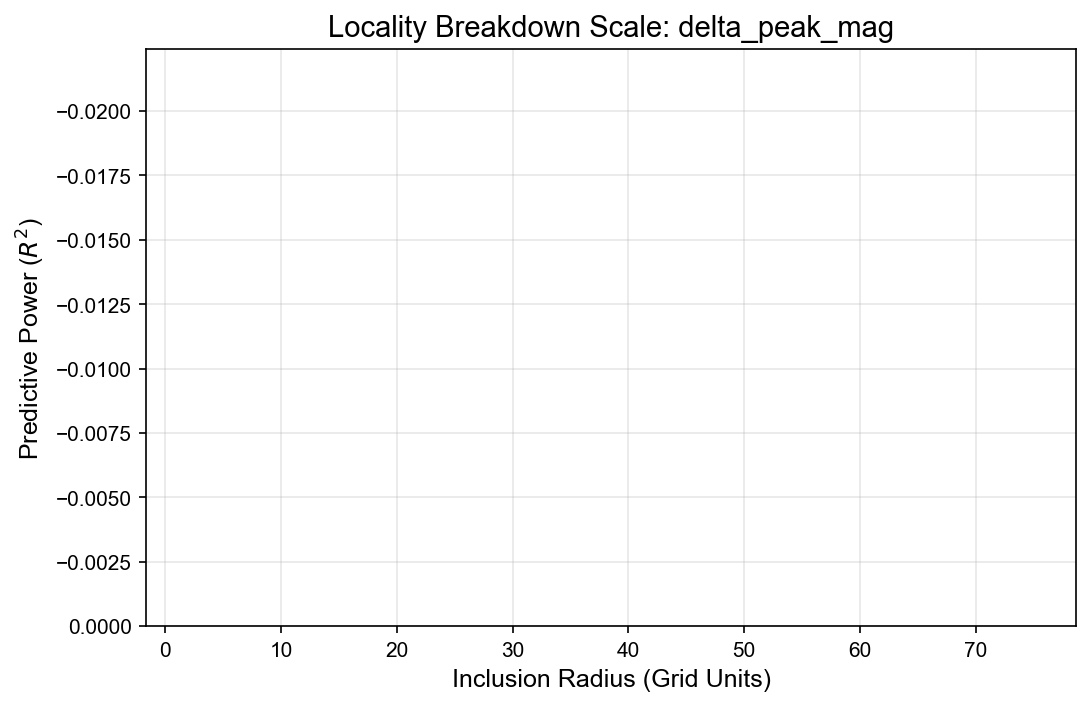

In [7]:
# Plot Scaling Curve
plt.figure(figsize=(8, 5))
plt.errorbar(scaling_df['Radius'], scaling_df['R2'], yerr=scaling_df['R2_Std'], 
             fmt='-o', color='crimson', capsize=5, linewidth=2)

plt.title(f'Locality Breakdown Scale: {target_col}')
plt.xlabel('Inclusion Radius (Grid Units)')
plt.ylabel('Predictive Power ($R^2$)')
plt.grid(True, alpha=0.3)
plt.ylim(bottom=0)

# Heuristic for saturation: where predictive power stops growing significantly
plt.savefig(OUTPUT_DIR / "Fig2_Locality_Scale.png", dpi=300)
plt.show()

## SECTION 4: Variance Decomposition

We formally decompose the variance of the target $Y$ into:
$$ Var(Y) = Var_{local} + Var_{global} + Var_{noise} $$

Method:
1.  Fit $Global$ First (Spatial only) $\rightarrow$ Get $\hat{Y}_{global}$.
2.  Fit $Local$ (Morphology) on Residuals $(Y - \hat{Y}_{global}) \rightarrow$ Get $\hat{Y}_{local}$.
3.  Calculate Variance of each component.

Decomposing Variance for delta_peak_wl...
Decomposing Variance for delta_peak_mag...


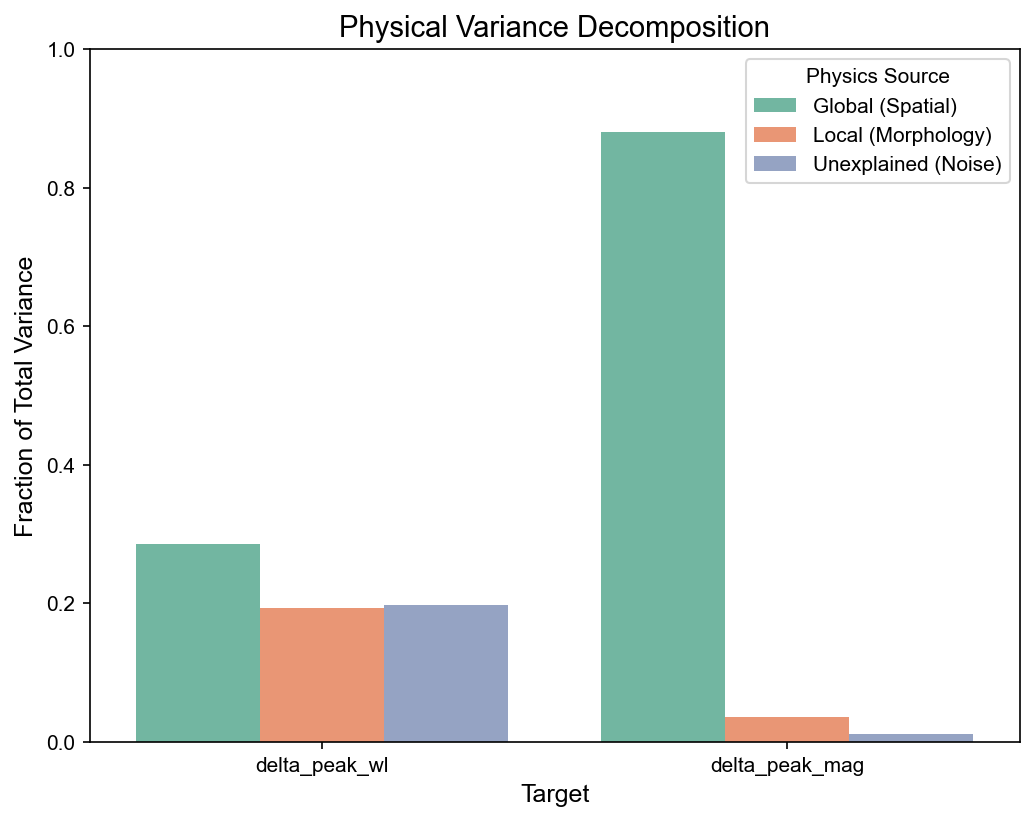

In [8]:
def decompose_variance(target_col, model_type="RF"):
    print(f"Decomposing Variance for {target_col}...")
    
    # Data
    y = master_df[target_col].values
    mask = ~np.isnan(y)
    y = y[mask]
    
    X_sp = master_df[feat_spatial].values[mask]
    X_rph = master_df[feat_morph].values[mask]
    
    # 1. Fit Global
    rf_glob = RandomForestRegressor(n_estimators=100, max_depth=8, n_jobs=-1, random_state=42)
    rf_glob.fit(X_sp, y)
    y_glob_pred = rf_glob.predict(X_sp)
    
    # 2. Fit Local on Residuals
    resids = y - y_glob_pred
    rf_loc = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
    rf_loc.fit(X_rph, resids)
    y_loc_pred = rf_loc.predict(X_rph)
    
    # 3. Calculate Variances
    var_total = np.var(y)
    var_glob = np.var(y_glob_pred)
    var_loc = np.var(y_loc_pred)
    
    # Unexplained is whatever is left from (y - glob - loc)
    final_resid = y - y_glob_pred - y_loc_pred
    var_noise = np.var(final_resid)
    
    # Fractions (Normalize by Total Variance)
    frac_glob = var_glob / var_total
    frac_loc = var_loc / var_total
    frac_noise = var_noise / var_total
    
    return {
        'Global (Spatial)': frac_glob,
        'Local (Morphology)': frac_loc,
        'Unexplained (Noise)': frac_noise
    }

results_decomp = []
for tgt in ['delta_peak_wl', 'delta_peak_mag']:
    res = decompose_variance(tgt)
    for k, v in res.items():
        results_decomp.append({'Target': tgt, 'Component': k, 'Variance Fraction': v})

df_decomp = pd.DataFrame(results_decomp)

# Plot Variance Decomposition
plt.figure(figsize=(8, 6))
sns.barplot(data=df_decomp, x='Target', y='Variance Fraction', hue='Component', palette='Set2')
plt.title('Physical Variance Decomposition')
plt.ylabel('Fraction of Total Variance')
plt.legend(title='Physics Source')
plt.ylim(0, 1.0)

plt.savefig(OUTPUT_DIR / "Fig3_Variance_Decomposition.png", dpi=300)
plt.show()

## SECTION 5: Predictability Phase Diagrams

We visualize Predictability (Mean Absolute Error) as a function of:
1.  **Defect Density** (Local Count in 32um radius)
2.  **Defect Proximity** (Distance to nearest defect)

This creates a map showing the physical regime where the model is valid.

c:\Users\srfdyz\.conda\envs\ci\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\srfdyz\.conda\envs\ci\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


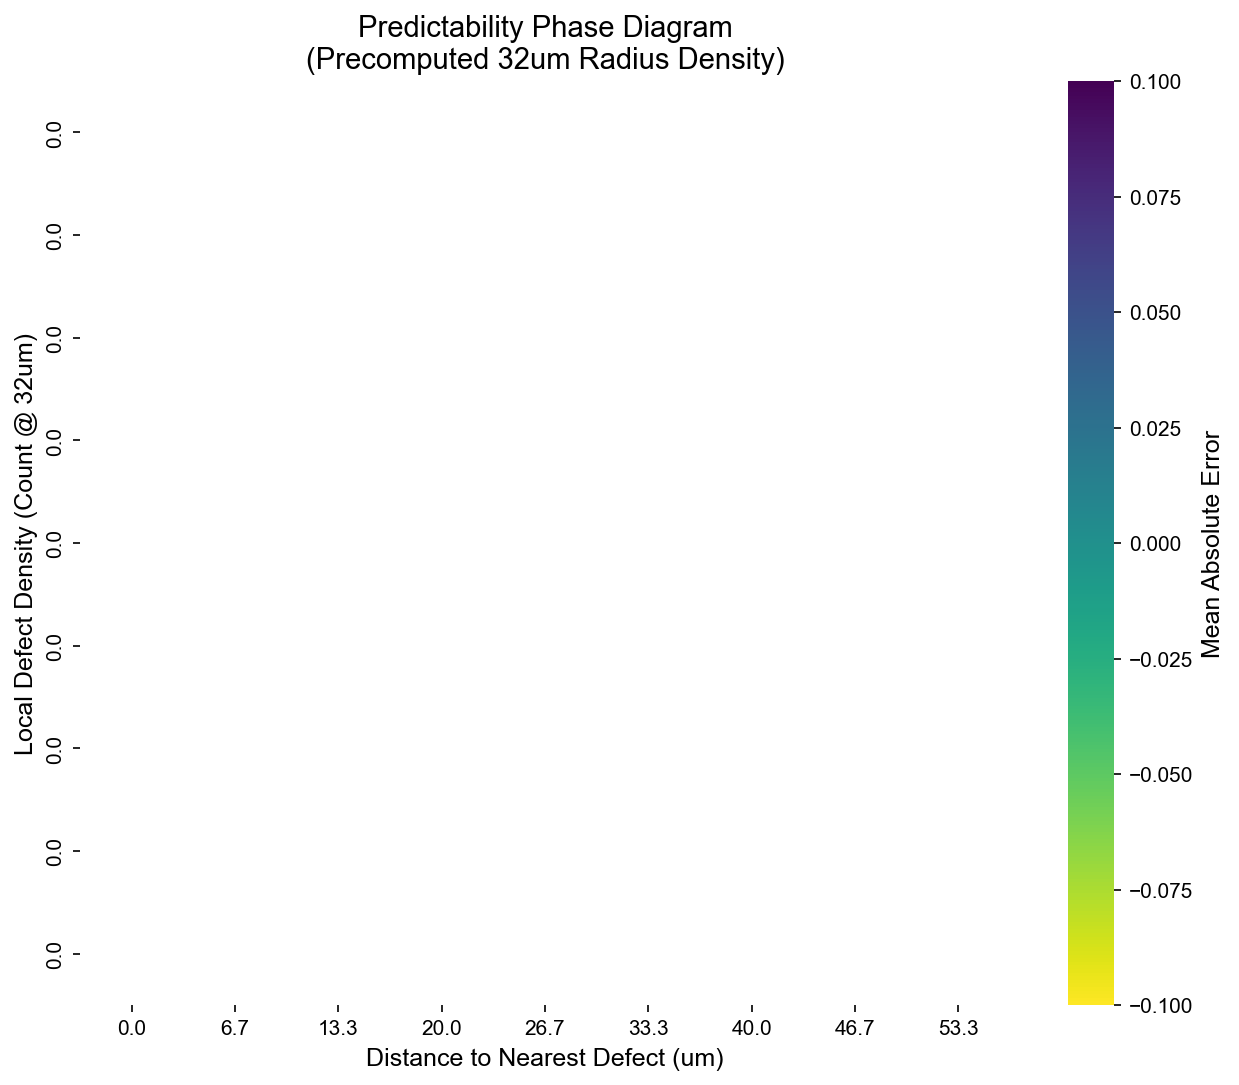

In [9]:
# Create Phase Diagram
target = 'delta_peak_mag'
X = master_df[feat_combined].values
y = master_df[target].values
mask = ~np.isnan(y)

# Get predictions (out of fold)
y_pred = np.zeros_like(y)
kf = GroupKFold(n_splits=5)
groups = master_df['spatial_group'].values

for train_idx, test_idx in kf.split(X, y, groups=groups):
    # Mask check
    train_idx = train_idx[np.isin(train_idx, np.where(mask)[0])]
    test_idx = test_idx[np.isin(test_idx, np.where(mask)[0])]
    
    X_train, y_train = X[train_idx], y[train_idx]
    X_test = X[test_idx]
    
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
    rf.fit(X_train, y_train)
    y_pred[test_idx] = rf.predict(X_test)

# Calculate Absolute Error
abs_error = np.abs(y[mask] - y_pred[mask])
df_map = master_df.loc[mask].copy()
df_map['abs_error'] = abs_error

# Define axes for Phase Diagram
# X-axis: Min Defect Dist (Proximity)
# Y-axis: Local Defect Count (Density) - e.g. at Radius 20 (approx 32um)
if 'defects_r20' not in df_map.columns:
    # Quick compute if not run in prev cells
    df_map['density_metric'] = df_map['n_total_defects']
else:
    df_map['density_metric'] = df_map['defects_r20']

# Create Bins
x_bins = np.linspace(df_map['min_defect_dist'].min(), 60, 10) # 0 to 60um
y_bins = np.linspace(df_map['density_metric'].min(), df_map['density_metric'].max(), 10)

# Compute mean error in bins
heatmap_data = np.zeros((len(y_bins)-1, len(x_bins)-1))
for i in range(len(y_bins)-1):
    for j in range(len(x_bins)-1):
        mask_bin = (
            (df_map['density_metric'] >= y_bins[i]) & (df_map['density_metric'] < y_bins[i+1]) &
            (df_map['min_defect_dist'] >= x_bins[j]) & (df_map['min_defect_dist'] < x_bins[j+1])
        )
        if mask_bin.sum() > 5: # Min samples
            heatmap_data[i, j] = df_map.loc[mask_bin, 'abs_error'].mean()
        else:
            heatmap_data[i, j] = np.nan

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, xticklabels=np.round(x_bins[:-1],1), yticklabels=np.round(y_bins[:-1],1), 
            cmap='viridis_r', annot=True, fmt='.2f', cbar_kws={'label': 'Mean Absolute Error'})
plt.title('Predictability Phase Diagram\n(Precomputed 32um Radius Density)')
plt.xlabel('Distance to Nearest Defect (um)')
plt.ylabel('Local Defect Density (Count @ 32um)')
plt.gca().invert_yaxis()
plt.savefig(OUTPUT_DIR / "Fig4_Predictability_Phase_Map.png", dpi=300)
plt.show()